In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
import requests
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
import re
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [39]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [40]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [41]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]].rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")

# Reformat to fit sparse matrix
my_books = pd.merge(df_books[["book_id", "title"]], my_books, how="inner", on="title")
my_books = pd.merge(book_index, my_books, how="left", left_on="book_id", right_on="book_id_x").fillna(0.)
my_books = np.array(my_books["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

# Replace 0 with 0.000001 to prevent cosine similarities from zeroing
sparse_fill = 0.000001
df_reviews.data[df_reviews.data == 0] = sparse_fill

# Normalize reviews within users
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

### 1.1 - User:User Collaborative Filtering with KNN

In [42]:
target = df_reviews.shape[0] - 1

In [43]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(columns={0:"uid",1:"book_index",2:"user_rating"})

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(ind_books.reset_index(), neighbor_user_ratings, how="inner", left_on="index", right_on="book_index")
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#([3-9]|[1-9]\d+)"
    regex2 = r"Vol. ([0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame([target_user_books, target_user_book_rat]).T.rename(columns={0:"book_index",1:"user_rating"})
    target_user_ratings = pd.merge(ind_books.reset_index(), target_user_ratings, how="inner", left_on="index", right_on="book_index")
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings

In [44]:
n_neighbors = 75
neighbor_user_ratings, target_user_ratings = find_neighbors(n_neighbors, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25151/2867291065.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25151/2867291065.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [45]:
# View neighbors rating table
neighbor_user_ratings.head()

,book_id,uid,book_index,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,...,Genre_16,Genre_17,Genre_18,Genre_19,Genre_20,Genre_21,Genre_22,Genre_23,Genre_24,Genre_25
0,100322,166222.0,1740.0,0.363803,Assata: An Autobiography,4.47,11057.0,1999,eng,https://images.gr-assets.com/books/1328857268m...,...,0.005139,0.005139,0.005139,0.005139,0.005139,0.005139,0.005139,0.005139,0.005139,0.005139
1,10182027,12967.0,12405.0,0.237171,The Girl's Guide to Homelessness: A Memoir,3.22,1727.0,2011,en-US,https://images.gr-assets.com/books/1299723800m...,...,0.005562,0.005562,0.005562,0.005562,0.005562,0.005562,0.005562,0.005562,0.005562,0.005562
2,10235,14822.0,16375.0,0.421076,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,2003,eng,https://s.gr-assets.com/assets/nophoto/book/11...,...,0.004412,0.004412,0.004412,0.004412,0.004412,0.004412,0.004412,0.004412,0.004412,0.004412
3,10290675,174067.0,20352.0,0.356034,"Electrified Sheep: Glass-Eating Scientists, Nu...",3.70,351.0,2011,NaN,https://images.gr-assets.com/books/1332785557m...,...,0.009713,0.766891,0.009713,0.009713,0.009713,0.009713,0.009713,0.009713,0.009713,0.009713
6,10316205,40144.0,22240.0,0.464238,Those Who Save Us,4.12,4984.0,2005,en-US,https://s.gr-assets.com/assets/nophoto/book/11...,...,0.005689,0.005689,0.005689,0.005689,0.863455,0.005689,0.005689,0.005689,0.005689,0.005689


### 1.2 - Generate Recommendations from Similar Readers

In [46]:
# 20 most popular books among similar readers
popular_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
    .nlargest(20, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)

popular_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
53,"March: Book One (March, #1)",4.34,21092.0,2013,2.7%
123,"The Reluctant Queen (The Queens of Renthia, #2)",4.06,684.0,2017,2.7%
61,New Boy,3.52,2029.0,2017,2.7%
80,Secrets of a Side Bitch 4,4.60,838.0,2015,1.3%
141,Topaz,4.59,875.0,1997,1.3%
79,Secrets of a Side Bitch 3,4.58,1181.0,2014,1.3%
54,"March: Book Two (March, #2)",4.54,10428.0,2015,1.3%
78,Secrets of a Side Bitch 2,4.54,1419.0,2013,1.3%
87,Spaceman: An Astronaut's Unlikely Journey to U...,4.54,990.0,2016,1.3%
126,The Simone Campbell Story: Secrets of a Side B...,4.54,449.0,2014,1.3%


In [47]:
# 10 highest rated books among similar readers
highest_rated_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
    .nlargest(20, "avg_rating").rename(columns={"book_id":"percent_similar_users_read"})

highest_rated_recs["percent_similar_users_read"] = (highest_rated_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)
highest_rated_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
80,Secrets of a Side Bitch 4,4.60,838.0,2015,1.3%
141,Topaz,4.59,875.0,1997,1.3%
79,Secrets of a Side Bitch 3,4.58,1181.0,2014,1.3%
54,"March: Book Two (March, #2)",4.54,10428.0,2015,1.3%
78,Secrets of a Side Bitch 2,4.54,1419.0,2013,1.3%
87,Spaceman: An Astronaut's Unlikely Journey to U...,4.54,990.0,2016,1.3%
126,The Simone Campbell Story: Secrets of a Side B...,4.54,449.0,2014,1.3%
147,War's Unwomanly Face,4.52,1182.0,1988,1.3%
47,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,2015,1.3%
11,Assata: An Autobiography,4.47,11057.0,1999,1.3%


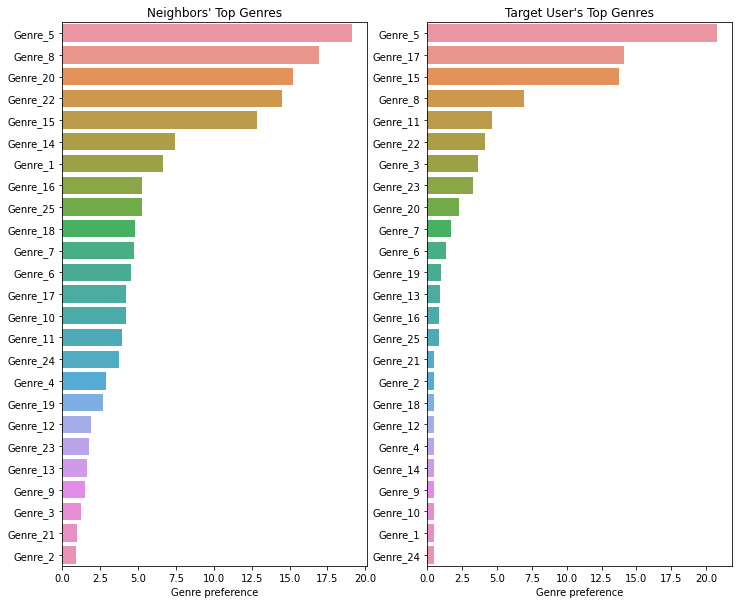

In [48]:
# Plot neighbors top genres
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
genre_ranking = pd.DataFrame(neighbor_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0,
    ax=ax[0]
)
ax[0].set_xlabel("Genre preference")
ax[0].set_title("Neighbors' Top Genres")

# Plot target reader's top genres
genre_ranking = pd.DataFrame(target_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0,
    ax=ax[1]
)
ax[1].set_xlabel("Genre preference")
ax[1].set_title("Target User's Top Genres")
plt.show()

In [49]:
# Loop through genres in descending relevance order and print top recs
for genre in genre_ranking.index[0:5]:
    
    g = float(genre[6:])
    highest_rated_recs_genre = neighbor_user_ratings.query("main_genre == @g")\
        .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .rename(columns={"book_id":"percent_similar_users_read"})

    highest_rated_recs_genre["percent_similar_users_read"] = highest_rated_recs_genre["percent_similar_users_read"] / n_neighbors
    highest_rated_recs_genre = highest_rated_recs_genre.query("ratings_count > 400 & avg_rating > 3.9")

    # Print genre name and descriptor
    for nt in genre_descriptors.itertuples():
        genre_rep = genre.replace("_"," ")
        if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
            print(nt.genre_string)
            
    display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(15))
    print("_____\n")

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
8,"March: Book Two (March, #2)",4.54,10428.0,https://www.goodreads.com/book/show/22487952-m...
18,War's Unwomanly Face,4.52,1182.0,https://www.goodreads.com/book/show/4025275-wa...
6,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
13,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
7,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
4,First They Killed My Father: A Daughter of Cam...,4.30,18580.0,https://www.goodreads.com/book/show/4373.First...
16,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...
5,Fortune is a Woman,4.21,992.0,https://www.goodreads.com/book/show/355715.For...
10,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
3,"The Clockwork Universe: Isaac Newton, the Roya...",3.91,3763.0,https://www.goodreads.com/book/show/9449985-th...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
10,The Invention of Nature: Alexander von Humbold...,4.29,4817.0,https://www.goodreads.com/book/show/23995249-t...
2,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
3,Gaviotas: A Village to Reinvent the World,4.17,555.0,https://www.goodreads.com/book/show/136893.Gav...
11,The Purity Myth: How America's Obsession with ...,4.06,5741.0,https://www.goodreads.com/book/show/4914761-th...
0,Alice in Wonderland,4.03,346530.0,https://www.goodreads.com/book/show/13023.Alic...
13,This is the Story of a Happy Marriage,4.03,13538.0,https://www.goodreads.com/book/show/17349222-t...
14,Voyage of the Beagle,4.03,4417.0,https://www.goodreads.com/book/show/183645.Voy...
7,Octavia's Brood: Science Fiction Stories from ...,3.94,1088.0,https://www.goodreads.com/book/show/23129839-o...
6,Nervous Conditions,3.92,6949.0,https://www.goodreads.com/book/show/158674.Ner...
8,Something New: Tales from a Makeshift Bride,3.92,4004.0,https://www.goodreads.com/book/show/22694572-s...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
12,The Power of a Praying Woman,4.38,9867.0,https://www.goodreads.com/book/show/18054709-t...
9,The (7L) The Seven Levels of Communication: Go...,4.33,482.0,https://www.goodreads.com/book/show/9858250-th...
15,Totto-chan: The Little Girl at the Window,4.30,14456.0,https://www.goodreads.com/book/show/328802.Tot...
0,"""I Give You My Body . . ."": How I Write Sex Sc...",4.21,481.0,https://www.goodreads.com/book/show/30719827-i...
4,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,53936.0,https://www.goodreads.com/book/show/10235.Moun...
14,Things No One Will Tell Fat Girls: A Handbook ...,4.06,1488.0,https://www.goodreads.com/book/show/24796533-t...
13,The Rational Optimist: How Prosperity Evolves,3.98,4894.0,https://www.goodreads.com/book/show/7776209-th...
8,Thank You for Being Late: An Optimist's Guide ...,3.96,3010.0,https://www.goodreads.com/book/show/26114127-t...
5,Quiet Power: The Secret Strengths of Introverts,3.93,1677.0,https://www.goodreads.com/book/show/23398681-q...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url


_____



### 2.1 - User:Item Collaborative Filtering with Matrix Factorization

In [50]:
# Find larger number of similar users than before to get broad pool of potentially relevant books
large_neighborhood_ratings, target_user_ratings = find_neighbors(1500, target, df_reviews, book_index, df_books)

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25151/2867291065.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_25151/2867291065.py:57: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]


In [51]:
# Get unique users and books to slice df_reviews
neighbor_index = large_neighborhood_ratings["uid"].unique()
neighbor_index = np.append(neighbor_index, target)
neighbor_book_index = large_neighborhood_ratings["book_index"].unique()
neighbor_book_index = np.append(neighbor_book_index, target_user_ratings["book_index"].unique())

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, neighbor_book_index]
R = R[neighbor_index, :]

In [52]:
# Decompose user ratings matrix R
U, sigma, Vt = svds(R, k = 5)
sigma = np.diag(sigma)

U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

### 2.2 - Generating Recommendations by Making Rating Predictions from Matrix Factorization

In [53]:
# Get predictions
# all_user_predicted_ratings = U.dot(sigma) @ Vt
all_user_predicted_ratings = U @ Vt
df_preds = pd.DataFrame(all_user_predicted_ratings.toarray(), columns=neighbor_book_index, index=neighbor_index).reset_index()

In [54]:
# Get target user's top predicted ratings
target_pred_books = df_preds[df_preds["index"] == target].columns[1:]
target_pred_ratings = df_preds[df_preds["index"] == target].values[0][1:]

# Put into df with relevant info from df_books
top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                .sort_values(by="predicted_rating", ascending=False)\
                .merge(book_index.reset_index(), left_on="book_index", right_on="index")\
                .merge(df_books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]], on="book_id")\
                .drop(columns=["index", "book_id"])

# Filter out already read books
top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
top_preds.drop(["book_index"], axis=1, inplace=True)
top_preds.query("avg_rating > 3.9").head(20)

,predicted_rating,title,avg_rating,ratings_count,year,main_genre,url
6,0.004816,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,7.0,https://www.goodreads.com/book/show/15819028-t...
7,0.004212,The Obstacle Is the Way: The Timeless Art of T...,4.11,13544.0,2014,8.0,https://www.goodreads.com/book/show/18668059-t...
8,0.004182,"The Broken Kingdoms (Inheritance, #2)",4.04,12827.0,2010,22.0,https://www.goodreads.com/book/show/7904453-th...
9,0.003984,Ninefox Gambit (The Machineries of Empire #1),3.91,3425.0,2016,22.0,https://www.goodreads.com/book/show/26118426-n...
10,0.003755,Open,4.18,48230.0,2009,5.0,https://www.goodreads.com/book/show/6480781-open
11,0.003490,Bad Feminist,3.91,43988.0,2014,16.0,https://www.goodreads.com/book/show/18813642-b...
12,0.003303,"Caliban's War (The Expanse, #2)",4.29,41459.0,2012,17.0,https://www.goodreads.com/book/show/12591698-c...
15,0.003125,The Battle For Justice In Palestine: The Case ...,4.25,182.0,2013,8.0,https://www.goodreads.com/book/show/17675081-t...
18,0.002763,"Steering by Starlight: Find Your Right Life, N...",4.16,1184.0,2008,8.0,https://www.goodreads.com/book/show/2185052.St...
19,0.002763,Guardians of Being,4.43,1104.0,2009,16.0,https://www.goodreads.com/book/show/6389355-gu...


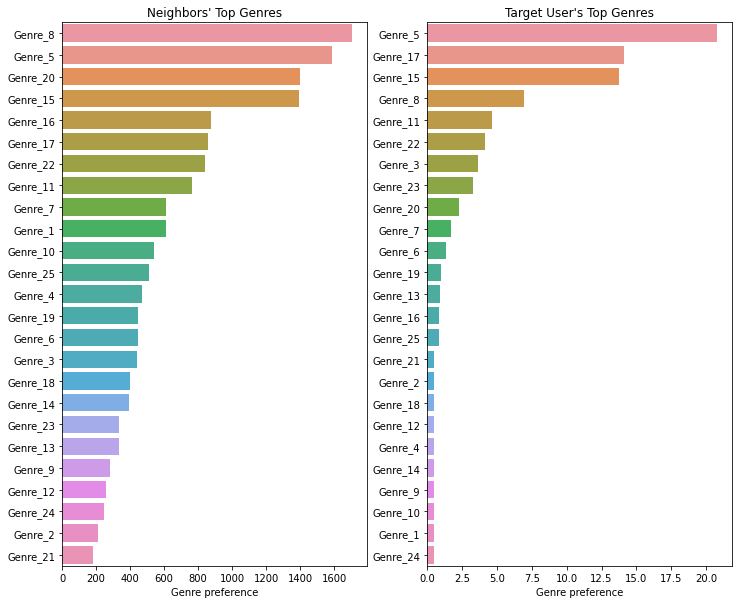

In [55]:
# Plot neighbors top genres
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
genre_ranking = pd.DataFrame(large_neighborhood_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0,
    ax=ax[0]
)
ax[0].set_xlabel("Genre preference")
ax[0].set_title("Neighbors' Top Genres")

# Plot target reader's top genres
genre_ranking = pd.DataFrame(target_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0,
    ax=ax[1]
)
ax[1].set_xlabel("Genre preference")
ax[1].set_title("Target User's Top Genres")
plt.show()

In [56]:
# Loop through genres in descending relevance order and print top recs
for genre in genre_ranking.index[0:5]:
    
    g = float(genre[6:])
    highest_rated_pred_genre = top_preds.query("main_genre == @g")\
        .sort_values(by="predicted_rating", ascending=False)\
        .query("ratings_count > 400 & avg_rating >= 4.15")\

    # Print genre name and descriptor
    for nt in genre_descriptors.itertuples():
        genre_rep = genre.replace("_"," ")
        if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
            print(nt.genre_string)
    
    display(highest_rated_pred_genre[["title", "avg_rating", "ratings_count","url"]].iloc[0:20,:])
    print("_____\n")

Genre 5: ['history', 'war', 'political', 'account', 'world', 'year', 'country', 'family', 'century', 'people']


,title,avg_rating,ratings_count,url
10,Open,4.18,48230.0,https://www.goodreads.com/book/show/6480781-open
52,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,https://www.goodreads.com/book/show/27220736-s...
108,The Coldest Winter: America and the Korean War,4.19,5070.0,https://www.goodreads.com/book/show/448135.The...
127,"March: Book Two (March, #2)",4.54,10428.0,https://www.goodreads.com/book/show/22487952-m...
147,"March: Book One (March, #1)",4.34,21092.0,https://www.goodreads.com/book/show/17346698-m...
173,The Motivation Manifesto,4.15,1702.0,https://www.goodreads.com/book/show/22891629-t...
225,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,https://www.goodreads.com/book/show/6792458-th...
228,Shoe Dog,4.44,5174.0,https://www.goodreads.com/book/show/4030991-sh...
247,In Order to Live: A North Korean Girl's Journe...,4.48,8076.0,https://www.goodreads.com/book/show/24611623-i...
269,"Rashed, My Friend",4.53,916.0,https://www.goodreads.com/book/show/4785973-ra...


_____

Genre 17: ['alien', 'planet', 'world', 'human', 'ship', 'space', 'war', 'crew', 'mission', 'race']


,title,avg_rating,ratings_count,url
12,"Caliban's War (The Expanse, #2)",4.29,41459.0,https://www.goodreads.com/book/show/12591698-c...
21,"Kings of the Wyld (The Band, #1)",4.42,2285.0,https://www.goodreads.com/book/show/30841984-k...
43,The Evolutionary Void,4.26,13729.0,https://www.goodreads.com/book/show/7438179-th...
44,The Abyss Beyond Dreams,4.21,4944.0,https://www.goodreads.com/book/show/20697413-t...
95,"Raven Stratagem (The Machineries of Empire, #2)",4.23,945.0,https://www.goodreads.com/book/show/30691976-r...
175,"Adulthood Rites (Xenogenesis, #2)",4.16,7081.0,https://www.goodreads.com/book/show/116249.Adu...
189,"The Scar (Bas-Lag, #2)",4.15,21122.0,https://www.goodreads.com/book/show/68497.The_...
284,"Wolf by Wolf (Wolf by Wolf, #1)",4.28,9710.0,https://www.goodreads.com/book/show/24807186-w...
391,"Machine Moon (Descender, #2)",4.20,3275.0,https://www.goodreads.com/book/show/28204537-d...
515,Lost Stars,4.25,9512.0,https://www.goodreads.com/book/show/25067046-l...


_____

Genre 15: ['history', 'poem', 'essay', 'text', 'century', 'collection', 'world', 'writing', 'introduction', 'literature']


,title,avg_rating,ratings_count,url
97,Feminism is for Everybody: Passionate Politics,4.18,7740.0,https://www.goodreads.com/book/show/168484.Fem...
114,"Short Stories from Hogwarts of Heroism, Hardsh...",4.23,16961.0,https://www.goodreads.com/book/show/31538635-s...
121,The Greatest Man Who Ever Lived,4.60,573.0,https://www.goodreads.com/book/show/2572990-th...
180,The Laugh of the Medusa,4.16,752.0,https://www.goodreads.com/book/show/11080013-t...
250,The Truth: An Uncomfortable Book About Relatio...,4.20,2503.0,https://www.goodreads.com/book/show/26887738-t...
274,Sixth of the Dusk,4.21,8122.0,https://www.goodreads.com/book/show/23397921-s...
315,The World of Ice & Fire: The Untold History of...,4.26,12952.0,https://www.goodreads.com/book/show/17345242-t...
466,"The Unreal and the Real: Selected Stories, Vol...",4.23,459.0,https://www.goodreads.com/book/show/13591879-t...
580,Cronopios and Famas,4.28,6449.0,https://www.goodreads.com/book/show/53423.Cron...
587,On the Shortness of Life,4.25,648.0,https://www.goodreads.com/book/show/1384442.On...


_____

Genre 8: ['guide', 'people', 'way', 'help', 'practical', 'world', 'experience', 'offer', 'question', 'business']


,title,avg_rating,ratings_count,url
18,"Steering by Starlight: Find Your Right Life, N...",4.16,1184.0,https://www.goodreads.com/book/show/2185052.St...
31,"No Death, No Fear",4.30,2017.0,https://www.goodreads.com/book/show/187636.No_...
42,The Book of Joy: Lasting Happiness in a Changi...,4.34,9067.0,https://www.goodreads.com/book/show/29496453-t...
51,Traction: A Startup Guide to Getting Customers,4.17,2209.0,https://www.goodreads.com/book/show/22091581-t...
55,Bigger Leaner Stronger: The Simple Science of ...,4.16,1236.0,https://www.goodreads.com/book/show/25049103-b...
66,Managing Oneself,4.15,3804.0,https://www.goodreads.com/book/show/2477223.Ma...
67,The Greatest Miracle in the World,4.27,1397.0,https://www.goodreads.com/book/show/897426.The...
76,EntreLeadership: 20 Years of Practical Busines...,4.19,8652.0,https://www.goodreads.com/book/show/11306337-e...
96,The Richest Man in Babylon,4.23,52607.0,https://www.goodreads.com/book/show/1052.The_R...
103,Six Pillars of Self-Esteem,4.17,3311.0,https://www.goodreads.com/book/show/79352.Six_...


_____

Genre 11: ['fiction', 'collection', 'world', 'literary', 'young', 'funny', 'short', 'comedy', 'horror', 'debut']


,title,avg_rating,ratings_count,url
267,The Refrigerator Monologues,4.21,894.0,https://www.goodreads.com/book/show/32714267-t...
1209,Hyperbole and a Half,4.17,3692.0,https://www.goodreads.com/book/show/17906245-h...
1213,Love's Executioner and Other Tales of Psychoth...,4.18,14376.0,https://www.goodreads.com/book/show/21027.Love...
1425,A Manual for Cleaning Women: Selected Stories,4.17,6863.0,https://www.goodreads.com/book/show/22929586-a...
1561,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
1952,The Exploits of Sherlock Holmes,4.41,26933.0,https://www.goodreads.com/book/show/76104.The_...
2851,In the Garden of the North American Martyrs,4.15,1706.0,https://www.goodreads.com/book/show/54510.In_t...
2965,Animal Farm / 1984,4.26,120269.0,https://www.goodreads.com/book/show/5472.Anima...
3091,The Faraway Nearby,4.19,3409.0,https://www.goodreads.com/book/show/16158561-t...
3252,Peter and Alice,4.44,561.0,https://www.goodreads.com/book/show/17347724-p...


_____

